# Deploying and Using CxrReportGen model for Inference using Batch Endpoints

This sample demonstrates how to deploy a CxrReportGen, a multimodal AI model that generates detailed, structured radiology reports from chest X-ray images, incorporating both current and prior images, along with key patient information, to an batch endpoint. For this notebook, we use Python 3.10 - AzureML SDK v2.

### Task
The CXRReportGen task processes chest X-ray images, generating a list of findings along with overlays on the images highlighting the areas of the image to which the findings are related.

In this notebook we will perform programmatic deployment of the model from the Azure AI Studio/Azure Machine Learning Studio Model Catalog, then send some images to the model, inspect the results and visualize the bounding boxes. Note that you can also perform deployment through the Model Catalog UI and use this notebook to issue calls to that endpoint.
 
### Model
The model is multimodal, using the BiomedClip architecture as the image encoder and the Phi-3-mini-4k-instruct architecture as the text encoder.

### Inference data
We will use chest X-ray images and text. 

### Outline
1. Setup pre-requisites
2. Pick a model to deploy
3. Deploy the model to an online endpoint
4. Test the endpoint
5. Clean up resources - delete the endpoint


## 1. Setup pre-requisites
* Connect to AzureML Workspace and authenticate.

In [ ]:
from azure.ai.ml import MLClient, Input
from azure.ai.ml.entities import (
    BatchEndpoint,
    ModelBatchDeployment,
    ModelBatchDeploymentSettings,
    Model,
    AmlCompute,
    Data,
    BatchRetrySettings,
    CodeConfiguration,
    Environment,
)
from azure.ai.ml.constants import AssetTypes, BatchDeploymentOutputAction
from azure.identity import DefaultAzureCredential
import pandas as pd

credential = DefaultAzureCredential()
ml_workspace = MLClient.from_config(credential)
print("Workspace:", ml_workspace)
ml_registry = MLClient(credential, registry_name="azureml")
print("Registry:", ml_registry)

### Look up the latest version of CxrReportGen

In [ ]:
model = ml_registry.models.get(name="CxrReportGen", label="latest")
model

### Create compute cluster

In [ ]:
compute_name = "cxr-batch-cluster"
if not any(filter(lambda m: m.name == compute_name, ml_workspace.compute.list())):
    compute_cluster = AmlCompute(
        name=compute_name,
        description="GPU cluster compute for CxrReportGen inference",
        min_instances=0,
        max_instances=1,
        size="Standard_NC24ads_A100_v4",
    )
    ml_workspace.compute.begin_create_or_update(compute_cluster).result()

### Create batch endpoint

In [ ]:
import random
import string

endpoint_prefix = "cxr-batch"
endpoint_list = list(
    filter(
        lambda m: m.name.startswith(endpoint_prefix),
        ml_workspace.batch_endpoints.list(),
    )
)

if endpoint_list:
    endpoint = endpoint_list and endpoint_list[0]
    print("Found existing endpoint:", endpoint.name)
else:
    # Creating a unique endpoint name by including a random suffix
    allowed_chars = string.ascii_lowercase + string.digits
    endpoint_suffix = "".join(random.choice(allowed_chars) for x in range(5))
    endpoint_name = f"{endpoint_prefix}-{endpoint_suffix}"
    endpoint = BatchEndpoint(
        name=endpoint_name,
        description="A batch endpoint for scoring images from CxrReportGen.",
        tags={"type": "CxrReportGen"},
    )
    ml_workspace.begin_create_or_update(endpoint).result()
    print(f"Created new endpoint: {endpoint_name}")

### Deploy CxrReportGen to batch endpoint

- **max_concurrency_per_instance**: Determines the number of worker process to spawn. Each worker process loads the model into GPU. We want to use multiple worker process to maximize GPU utilization, but not exceed available GPU memory.
- **retry_settings**: Timeout may need to be adjusted based on batch size. Larger batch size requires longer timeout; otherwise, worker process may end prematurely.

In [ ]:
deployment = ModelBatchDeployment(
    name="cxr-dpl",
    description="A deployment for model CxrReportGen",
    endpoint_name=endpoint.name,
    model=model,
    compute=compute_name,
    settings=ModelBatchDeploymentSettings(
        max_concurrency_per_instance=1,
        mini_batch_size=1,
        instance_count=1,
        output_action=BatchDeploymentOutputAction.APPEND_ROW,
        output_file_name="predictions.csv",
        retry_settings=BatchRetrySettings(max_retries=3, timeout=300),
        logging_level="info",
    ),
)
ml_workspace.begin_create_or_update(deployment).result()

In [ ]:
endpoint = ml_workspace.batch_endpoints.get(endpoint.name)
endpoint.defaults.deployment_name = deployment.name
ml_workspace.batch_endpoints.begin_create_or_update(endpoint).result()
print(f"The default deployment is {endpoint.defaults.deployment_name}")

## 4. Test the endpoint - base64 encoded image and text

### Load test dataset
Download the test dataset using command `azcopy copy --recursive https://azuremlexampledata.blob.core.windows.net/data/healthcare-ai/ /home/azureuser/data/`

### Create the input CSV file

In [ ]:
import base64
import os


def read_base64_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")


frontal = "/home/azureuser/data/healthcare-ai/cxrreportgen-images/cxr_frontal.jpg"
lateral = "/home/azureuser/data/healthcare-ai/cxrreportgen-images/cxr_lateral.jpg"

data = [
    {
        "frontal_image": read_base64_image(frontal),
        "lateral_image": read_base64_image(lateral),
        "indication": "",
        "technique": "",
        "comparison": "None",
    }
]

csv_path = os.path.join("batch_input.csv")
df_input = pd.DataFrame(data)
df_input.to_csv(csv_path)

### Load the test dataset into AzureML

In [ ]:
dataset_name = "cxr-png-dataset"

png_dataset = Data(
    path=csv_path,
    type=AssetTypes.URI_FILE,
    description="An unlabeled dataset for heart classification",
    name=dataset_name,
)

ml_workspace.data.create_or_update(png_dataset)

### Verify the test dataset is uploaded successfully

In [ ]:
ml_workspace.data.get(name=dataset_name, label="latest")

### Submit a job to the batch endpoint

In [ ]:
input = Input(type=AssetTypes.URI_FILE, path=png_dataset.path)
input

In [ ]:
job = ml_workspace.batch_endpoints.invoke(endpoint_name=endpoint.name, input=input)

In [ ]:
# Monitor job progress
ml_workspace.jobs.stream(job.name)

### Download the job output
CxrReportGen output can be found in file `named-outputs/score/predictions.csv`

In [ ]:
scoring_job = list(ml_workspace.jobs.list(parent_job_name=job.name))[0]
scoring_job

In [ ]:
ml_workspace.jobs.download(
    name=scoring_job.name, download_path=".", output_name="score"
)

### Load job result

In [ ]:
pred_csv_path = os.path.join("named-outputs", "score", "predictions.csv")
df_result = pd.read_csv(pred_csv_path, header=None)
print("df_result.shape:", df_result.shape)
print(df_result.iloc[0])  # print first row

### Display job result

In [ ]:
import json
import base64
from PIL import Image
import matplotlib.pyplot as plt
from PIL import Image


def adjust_box_for_original_image_size(norm_box, width: int, height: int):
    """
    Assuming we did a centre crop to the shortest size, adjust the box coordinates back to the original shape of the image.
    :param norm_box: A normalized box to rescale.
    :param width: Original width of the image, in pixels.
    :param height: Original height of the image, in pixels.
    :return: The box normalized relative to the original size of the image.
    """
    crop_width = crop_height = min(width, height)
    x_offset = (width - crop_width) // 2
    y_offset = (height - crop_height) // 2
    norm_x_min, norm_y_min, norm_x_max, norm_y_max = norm_box
    abs_x_min = int(norm_x_min * crop_width + x_offset)
    abs_x_max = int(norm_x_max * crop_width + x_offset)
    abs_y_min = int(norm_y_min * crop_height + y_offset)
    abs_y_max = int(norm_y_max * crop_height + y_offset)
    adjusted_norm_x_min = abs_x_min / width
    adjusted_norm_x_max = abs_x_max / width
    adjusted_norm_y_min = abs_y_min / height
    adjusted_norm_y_max = abs_y_max / height
    return (
        adjusted_norm_x_min,
        adjusted_norm_y_min,
        adjusted_norm_x_max,
        adjusted_norm_y_max,
    )


def show_image_with_bbox(path_frontal, findings, path_lateral=None):
    """Displays frontal and lateral images with bounding boxes around the findings."""
    image_frontal = Image.open(path_frontal)
    width_frontal, height_frontal = image_frontal.size

    if path_lateral:
        image_lateral = Image.open(path_lateral)
        _, axes = plt.subplots(1, 2, figsize=(20, 10))
        axes[0].imshow(image_frontal, cmap="gray")
        axes[1].imshow(image_lateral, cmap="gray")
    else:
        _, axes = plt.subplots(figsize=(10, 10))
        axes.imshow(image_frontal, cmap="gray")
        axes = [axes]

    findings_str = []
    for idx, (finding, boxes) in enumerate(findings):
        findings_str.append(f"{idx}. {finding}{' * ' if boxes else ' '}")
        if boxes:
            for box in boxes:
                box = adjust_box_for_original_image_size(
                    box, width_frontal, height_frontal
                )
                x_min, y_min, x_max, y_max = (
                    box[0] * width_frontal,
                    box[1] * height_frontal,
                    box[2] * width_frontal,
                    box[3] * height_frontal,
                )

                rect = plt.Rectangle(
                    (x_min, y_min),
                    x_max - x_min,
                    y_max - y_min,
                    edgecolor="red",
                    facecolor="none",
                    linewidth=2,
                )
                axes[0].add_patch(rect)
                axes[0].text(
                    x_min + 3,
                    y_min + 3,
                    f"Finding ID: {idx}",
                    color="yellow",
                    fontsize=10,
                    verticalalignment="top",
                )

    for ax in axes:
        ax.axis("off")  # Hide the axes

    plt.show()
    print("\n".join(findings_str))

In [29]:
findings = json.loads(df_result.iloc[0][1])
findings

[['A new right lower lobe infiltrate has developed.',
  [[0.115, 0.495, 0.435, 0.815]]],
 ['The remainder the chest is essentially unchanged.', None]]

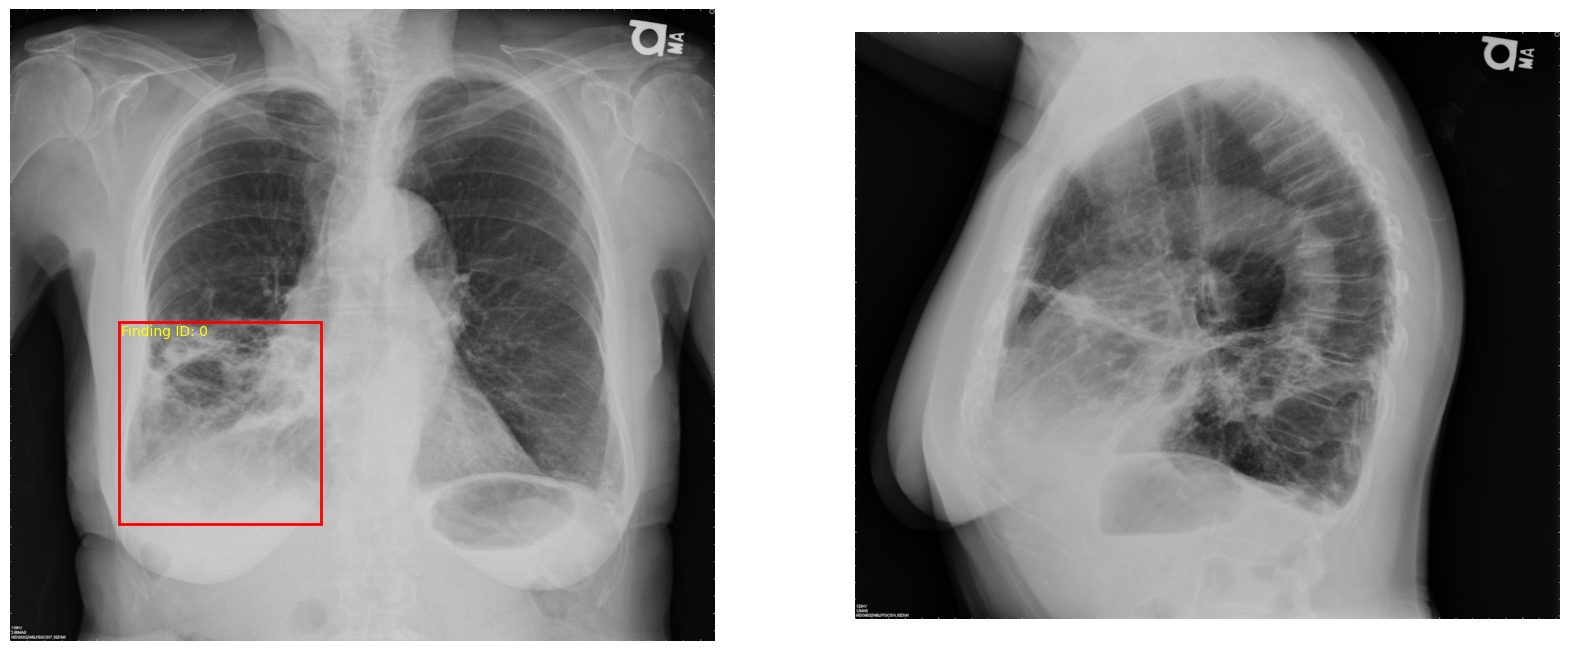

0. A new right lower lobe infiltrate has developed. * 
1. The remainder the chest is essentially unchanged. 


In [30]:
show_image_with_bbox(frontal, findings, path_lateral=lateral)

## 5. Clean up resources - delete the batch endpoint

In [ ]:
ml_workspace.batch_endpoints.begin_delete(endpoint_name).result()